# 루브릭

평가문항	상세기준

1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.
	데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.

2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.
	U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.

3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.
	10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

# 수행사항

1.    데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
    (어떠한 방법을 사용했는지 적어주세요.)
2.    이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
3.    모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
4.    1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
5.    모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.


# pix2pix model
이미지를 입력으로 해서 원하는 다른 형태의 이미지를 변환하는 모델!

In [1]:

import os

data_path = os.getenv('HOME')+'/aiffel/aiffel_exp_data/cityscapes/train/'
print("train examples :", len(os.listdir(data_path)))

train examples : 1000


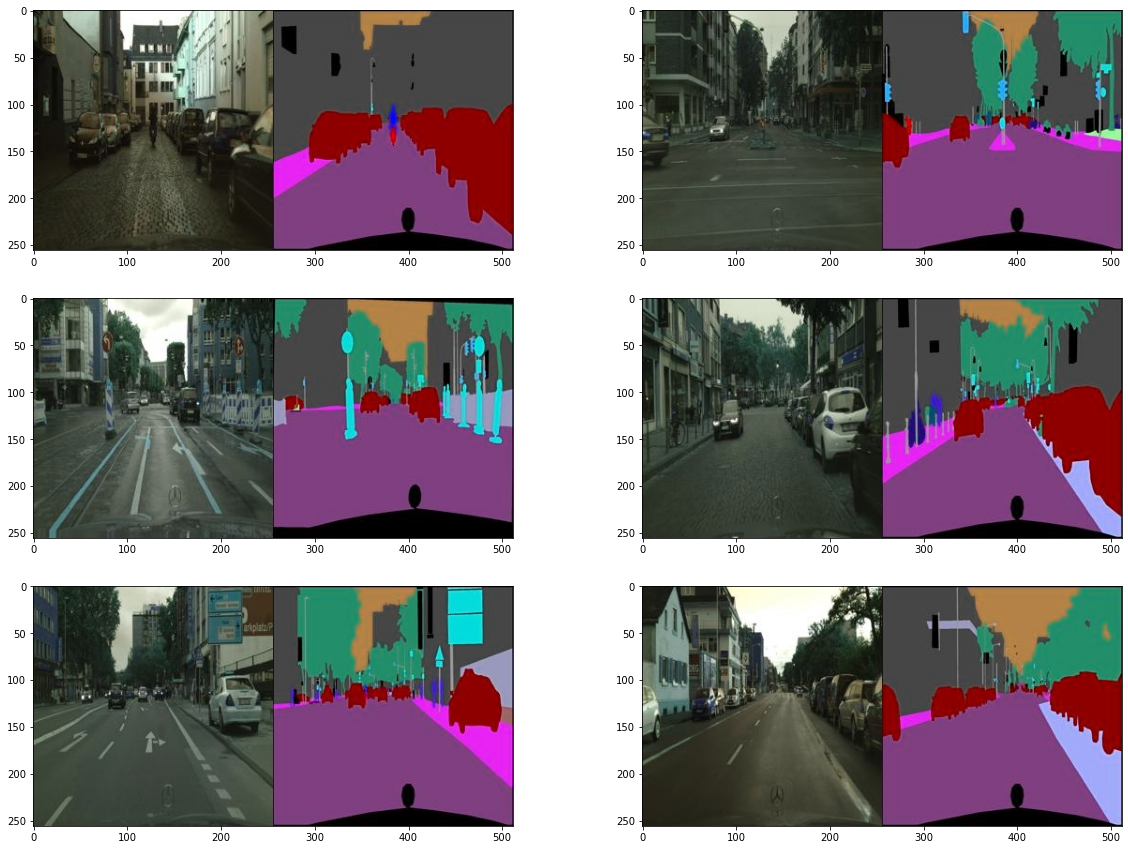

In [2]:
#이미지 임의로 6장 선택 시각화
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


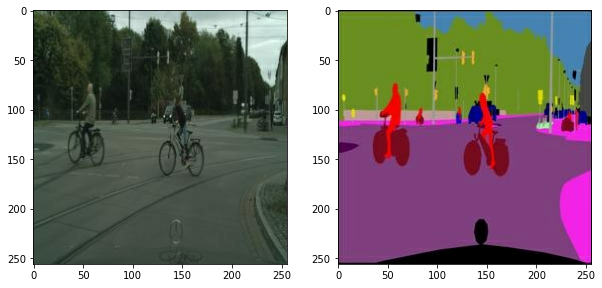

In [4]:

# 2개 이미지로 분할 
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

목표: 첫번째 그림을  pix2pix모델에 넣어서 두번째 그림과 같은 이미지를 생성하는 것

* 하지만 데이터의 양이 적어서 다양성을 높이기 위해서 여러 augmentation방법을 적용

aumentation = 각도, 색상, 밝기, 흐림정도를 조절해서 이미지를 더 다양한 상황해서 학습하여 정확도를 높이는 방법

# augmentation

In [5]:
# augmentation

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("적용")

적용


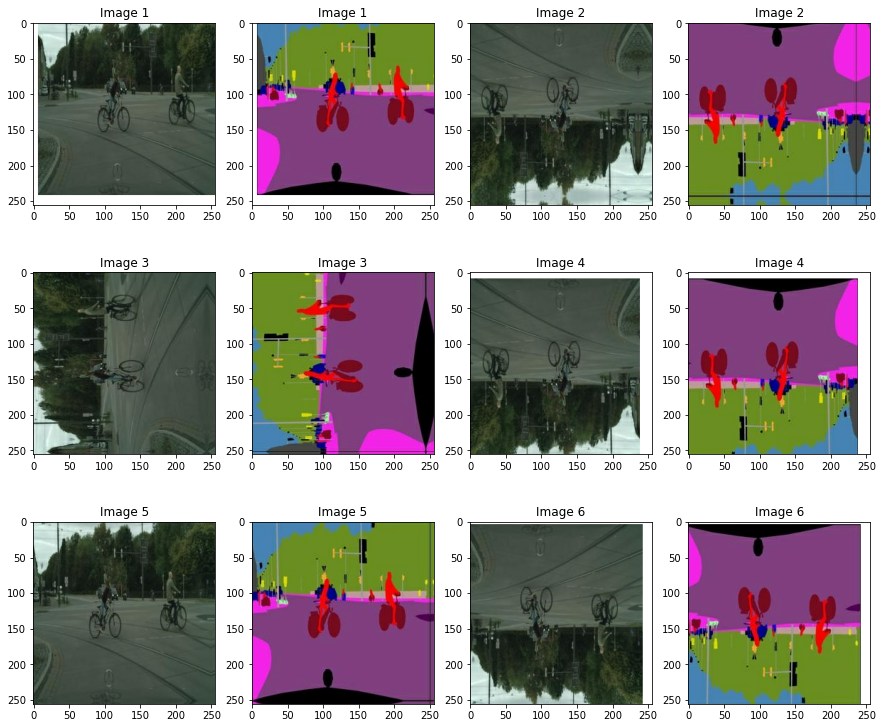

In [6]:
#시각화 
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

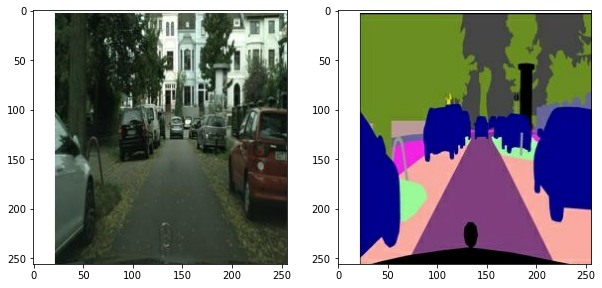

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 모델 구현

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("인코더")

인코더


In [9]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

# 디코더

In [10]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("디코더")

디코더


In [11]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

# 생성자 구현

In [12]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("UNet")

UNet


In [13]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_8 (EncodeBlock)    (None, 128, 128, 64) 3072        input_3[0][0]                    
__________________________________________________________________________________________________
encode_block_9 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block_8[0][0]             
__________________________________________________________________________________________________
encode_block_10 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_9[0][0]             
____________________________________________________________________________________________

# Discriminator

In [14]:

class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("Discriminator")

Discriminator


In [15]:

inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_30 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [16]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [17]:
#블록 출력크기 확인
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

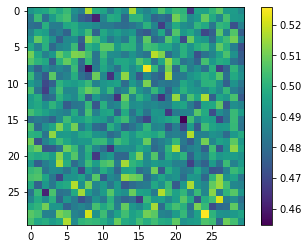

In [18]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# 손실함수 적용하기

In [19]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("생성자 손실함수, 판별자 손실함수")

생성자 손실함수, 판별자 손실함수


In [20]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("OPTIMIZER")

OPTIMIZER


In [21]:

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("가중치 업데이트")

가중치 업데이트


# 학습과정과 테스트

In [22]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.1097                     
L1_loss:0.3297                     
Discriminator_loss:1.2225

EPOCH[1] - STEP[20]                     
Generator_loss:1.1656                     
L1_loss:0.2437                     
Discriminator_loss:0.9740

EPOCH[1] - STEP[30]                     
Generator_loss:1.4151                     
L1_loss:0.3643                     
Discriminator_loss:0.8052

EPOCH[1] - STEP[40]                     
Generator_loss:1.7919                     
L1_loss:0.2584                     
Discriminator_loss:0.5200

EPOCH[1] - STEP[50]                     
Generator_loss:2.4043                     
L1_loss:0.2729                     
Discriminator_loss:0.4572

EPOCH[1] - STEP[60]                     
Generator_loss:2.5533                     
L1_loss:0.2476                     
Discriminator_loss:0.5344

EPOCH[1] - STEP[70]                     
Generator_loss:2.4681                     
L1_loss:0.2230                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.5825                     
L1_loss:0.1948                     
Discriminator_loss:0.4627

EPOCH[3] - STEP[80]                     
Generator_loss:0.6039                     
L1_loss:0.2333                     
Discriminator_loss:1.0574

EPOCH[3] - STEP[90]                     
Generator_loss:1.1326                     
L1_loss:0.2023                     
Discriminator_loss:0.8494

EPOCH[3] - STEP[100]                     
Generator_loss:1.2266                     
L1_loss:0.1792                     
Discriminator_loss:0.5550

EPOCH[3] - STEP[110]                     
Generator_loss:2.2047                     
L1_loss:0.1988                     
Discriminator_loss:0.6933

EPOCH[3] - STEP[120]                     
Generator_loss:1.8406                     
L1_loss:0.2256                     
Discriminator_loss:0.4003

EPOCH[3] - STEP[130]                     
Generator_loss:0.9455                     
L1_loss:0.2289                

EPOCH[5] - STEP[130]                     
Generator_loss:3.1577                     
L1_loss:0.1965                     
Discriminator_loss:1.3108

EPOCH[5] - STEP[140]                     
Generator_loss:0.9649                     
L1_loss:0.2539                     
Discriminator_loss:0.7641

EPOCH[5] - STEP[150]                     
Generator_loss:1.4641                     
L1_loss:0.1836                     
Discriminator_loss:1.1530

EPOCH[5] - STEP[160]                     
Generator_loss:2.0034                     
L1_loss:0.1997                     
Discriminator_loss:0.7157

EPOCH[5] - STEP[170]                     
Generator_loss:1.3761                     
L1_loss:0.1819                     
Discriminator_loss:0.8417

EPOCH[5] - STEP[180]                     
Generator_loss:1.5267                     
L1_loss:0.2203                     
Discriminator_loss:0.9144

EPOCH[5] - STEP[190]                     
Generator_loss:0.8287                     
L1_loss:0.1850             

EPOCH[7] - STEP[190]                     
Generator_loss:2.6981                     
L1_loss:0.1701                     
Discriminator_loss:1.7214

EPOCH[7] - STEP[200]                     
Generator_loss:1.2137                     
L1_loss:0.1813                     
Discriminator_loss:0.6989

EPOCH[7] - STEP[210]                     
Generator_loss:1.1753                     
L1_loss:0.1995                     
Discriminator_loss:0.7669

EPOCH[7] - STEP[220]                     
Generator_loss:1.2559                     
L1_loss:0.2251                     
Discriminator_loss:0.5657

EPOCH[7] - STEP[230]                     
Generator_loss:2.2464                     
L1_loss:0.1695                     
Discriminator_loss:1.6251

EPOCH[7] - STEP[240]                     
Generator_loss:2.0912                     
L1_loss:0.1990                     
Discriminator_loss:1.3122

EPOCH[7] - STEP[250]                     
Generator_loss:1.0286                     
L1_loss:0.1888             

EPOCH[9] - STEP[250]                     
Generator_loss:0.5085                     
L1_loss:0.1954                     
Discriminator_loss:1.2036

EPOCH[10] - STEP[10]                     
Generator_loss:1.0072                     
L1_loss:0.2005                     
Discriminator_loss:0.8041

EPOCH[10] - STEP[20]                     
Generator_loss:0.7213                     
L1_loss:0.1520                     
Discriminator_loss:0.9250

EPOCH[10] - STEP[30]                     
Generator_loss:1.3198                     
L1_loss:0.1830                     
Discriminator_loss:0.4952

EPOCH[10] - STEP[40]                     
Generator_loss:2.9470                     
L1_loss:0.1559                     
Discriminator_loss:1.1244

EPOCH[10] - STEP[50]                     
Generator_loss:1.5030                     
L1_loss:0.1702                     
Discriminator_loss:0.8024

EPOCH[10] - STEP[60]                     
Generator_loss:1.2685                     
L1_loss:0.1575             

EPOCH[12] - STEP[60]                     
Generator_loss:2.6151                     
L1_loss:0.1706                     
Discriminator_loss:1.1017

EPOCH[12] - STEP[70]                     
Generator_loss:1.4865                     
L1_loss:0.1741                     
Discriminator_loss:1.0767

EPOCH[12] - STEP[80]                     
Generator_loss:0.8794                     
L1_loss:0.1717                     
Discriminator_loss:0.8094

EPOCH[12] - STEP[90]                     
Generator_loss:1.5714                     
L1_loss:0.1856                     
Discriminator_loss:0.6594

EPOCH[12] - STEP[100]                     
Generator_loss:2.3060                     
L1_loss:0.1801                     
Discriminator_loss:0.4407

EPOCH[12] - STEP[110]                     
Generator_loss:1.3427                     
L1_loss:0.2177                     
Discriminator_loss:0.3875

EPOCH[12] - STEP[120]                     
Generator_loss:1.7484                     
L1_loss:0.1967          

EPOCH[14] - STEP[120]                     
Generator_loss:2.3916                     
L1_loss:0.1620                     
Discriminator_loss:0.4803

EPOCH[14] - STEP[130]                     
Generator_loss:0.9070                     
L1_loss:0.2088                     
Discriminator_loss:0.9047

EPOCH[14] - STEP[140]                     
Generator_loss:2.3452                     
L1_loss:0.1373                     
Discriminator_loss:2.0097

EPOCH[14] - STEP[150]                     
Generator_loss:1.1323                     
L1_loss:0.1364                     
Discriminator_loss:0.9789

EPOCH[14] - STEP[160]                     
Generator_loss:1.9377                     
L1_loss:0.1945                     
Discriminator_loss:0.5812

EPOCH[14] - STEP[170]                     
Generator_loss:0.9879                     
L1_loss:0.1614                     
Discriminator_loss:0.9023

EPOCH[14] - STEP[180]                     
Generator_loss:1.8828                     
L1_loss:0.1552      

EPOCH[16] - STEP[180]                     
Generator_loss:1.9130                     
L1_loss:0.2026                     
Discriminator_loss:0.6731

EPOCH[16] - STEP[190]                     
Generator_loss:1.9801                     
L1_loss:0.1630                     
Discriminator_loss:0.3288

EPOCH[16] - STEP[200]                     
Generator_loss:1.8652                     
L1_loss:0.1455                     
Discriminator_loss:0.3500

EPOCH[16] - STEP[210]                     
Generator_loss:1.9062                     
L1_loss:0.1838                     
Discriminator_loss:0.4852

EPOCH[16] - STEP[220]                     
Generator_loss:2.5325                     
L1_loss:0.1378                     
Discriminator_loss:1.7645

EPOCH[16] - STEP[230]                     
Generator_loss:1.1440                     
L1_loss:0.2065                     
Discriminator_loss:0.7914

EPOCH[16] - STEP[240]                     
Generator_loss:1.0413                     
L1_loss:0.2018      

EPOCH[18] - STEP[240]                     
Generator_loss:0.7804                     
L1_loss:0.1474                     
Discriminator_loss:1.1092

EPOCH[18] - STEP[250]                     
Generator_loss:1.6090                     
L1_loss:0.1829                     
Discriminator_loss:0.4175

EPOCH[19] - STEP[10]                     
Generator_loss:1.8276                     
L1_loss:0.1721                     
Discriminator_loss:1.0353

EPOCH[19] - STEP[20]                     
Generator_loss:1.7983                     
L1_loss:0.1294                     
Discriminator_loss:1.2801

EPOCH[19] - STEP[30]                     
Generator_loss:1.5568                     
L1_loss:0.1577                     
Discriminator_loss:0.5681

EPOCH[19] - STEP[40]                     
Generator_loss:1.9473                     
L1_loss:0.2041                     
Discriminator_loss:0.6664

EPOCH[19] - STEP[50]                     
Generator_loss:1.5494                     
L1_loss:0.1534           

EPOCH[21] - STEP[50]                     
Generator_loss:2.3611                     
L1_loss:0.1582                     
Discriminator_loss:0.5597

EPOCH[21] - STEP[60]                     
Generator_loss:2.0610                     
L1_loss:0.1914                     
Discriminator_loss:0.3373

EPOCH[21] - STEP[70]                     
Generator_loss:0.6720                     
L1_loss:0.1820                     
Discriminator_loss:1.0245

EPOCH[21] - STEP[80]                     
Generator_loss:3.4195                     
L1_loss:0.1857                     
Discriminator_loss:0.8698

EPOCH[21] - STEP[90]                     
Generator_loss:1.1826                     
L1_loss:0.1291                     
Discriminator_loss:0.9384

EPOCH[21] - STEP[100]                     
Generator_loss:3.1185                     
L1_loss:0.1569                     
Discriminator_loss:1.3512

EPOCH[21] - STEP[110]                     
Generator_loss:1.1824                     
L1_loss:0.1670           

EPOCH[23] - STEP[110]                     
Generator_loss:1.5076                     
L1_loss:0.1507                     
Discriminator_loss:0.9607

EPOCH[23] - STEP[120]                     
Generator_loss:1.6456                     
L1_loss:0.1752                     
Discriminator_loss:0.7017

EPOCH[23] - STEP[130]                     
Generator_loss:2.1234                     
L1_loss:0.1465                     
Discriminator_loss:1.3186

EPOCH[23] - STEP[140]                     
Generator_loss:2.3370                     
L1_loss:0.1204                     
Discriminator_loss:0.7846

EPOCH[23] - STEP[150]                     
Generator_loss:3.7021                     
L1_loss:0.1513                     
Discriminator_loss:1.8402

EPOCH[23] - STEP[160]                     
Generator_loss:1.9473                     
L1_loss:0.1546                     
Discriminator_loss:0.3744

EPOCH[23] - STEP[170]                     
Generator_loss:0.5050                     
L1_loss:0.1754      

EPOCH[25] - STEP[170]                     
Generator_loss:1.8399                     
L1_loss:0.1616                     
Discriminator_loss:0.3362

EPOCH[25] - STEP[180]                     
Generator_loss:2.5228                     
L1_loss:0.1565                     
Discriminator_loss:1.1456

EPOCH[25] - STEP[190]                     
Generator_loss:2.1143                     
L1_loss:0.1638                     
Discriminator_loss:0.9802

EPOCH[25] - STEP[200]                     
Generator_loss:2.2158                     
L1_loss:0.1509                     
Discriminator_loss:0.3091

EPOCH[25] - STEP[210]                     
Generator_loss:2.6529                     
L1_loss:0.1657                     
Discriminator_loss:0.2945

EPOCH[25] - STEP[220]                     
Generator_loss:1.5885                     
L1_loss:0.1502                     
Discriminator_loss:0.5956

EPOCH[25] - STEP[230]                     
Generator_loss:2.9727                     
L1_loss:0.1593      

EPOCH[27] - STEP[230]                     
Generator_loss:3.6365                     
L1_loss:0.1521                     
Discriminator_loss:0.3859

EPOCH[27] - STEP[240]                     
Generator_loss:1.6030                     
L1_loss:0.1525                     
Discriminator_loss:0.4508

EPOCH[27] - STEP[250]                     
Generator_loss:0.6566                     
L1_loss:0.1611                     
Discriminator_loss:0.9588

EPOCH[28] - STEP[10]                     
Generator_loss:1.2989                     
L1_loss:0.1521                     
Discriminator_loss:0.5892

EPOCH[28] - STEP[20]                     
Generator_loss:1.9930                     
L1_loss:0.1735                     
Discriminator_loss:0.2233

EPOCH[28] - STEP[30]                     
Generator_loss:1.8403                     
L1_loss:0.1476                     
Discriminator_loss:0.4897

EPOCH[28] - STEP[40]                     
Generator_loss:1.5730                     
L1_loss:0.1824          

EPOCH[30] - STEP[40]                     
Generator_loss:1.7702                     
L1_loss:0.1504                     
Discriminator_loss:0.5171

EPOCH[30] - STEP[50]                     
Generator_loss:2.9046                     
L1_loss:0.1442                     
Discriminator_loss:0.6987

EPOCH[30] - STEP[60]                     
Generator_loss:3.7309                     
L1_loss:0.1541                     
Discriminator_loss:0.4194

EPOCH[30] - STEP[70]                     
Generator_loss:2.9588                     
L1_loss:0.1983                     
Discriminator_loss:0.3949

EPOCH[30] - STEP[80]                     
Generator_loss:1.1397                     
L1_loss:0.1459                     
Discriminator_loss:0.6484

EPOCH[30] - STEP[90]                     
Generator_loss:1.0644                     
L1_loss:0.1352                     
Discriminator_loss:0.8655

EPOCH[30] - STEP[100]                     
Generator_loss:0.5725                     
L1_loss:0.1420            

EPOCH[32] - STEP[100]                     
Generator_loss:1.5540                     
L1_loss:0.1813                     
Discriminator_loss:0.6233

EPOCH[32] - STEP[110]                     
Generator_loss:1.5641                     
L1_loss:0.1553                     
Discriminator_loss:0.3212

EPOCH[32] - STEP[120]                     
Generator_loss:2.7881                     
L1_loss:0.1383                     
Discriminator_loss:1.4608

EPOCH[32] - STEP[130]                     
Generator_loss:1.6964                     
L1_loss:0.1529                     
Discriminator_loss:0.4088

EPOCH[32] - STEP[140]                     
Generator_loss:2.4405                     
L1_loss:0.1409                     
Discriminator_loss:1.1929

EPOCH[32] - STEP[150]                     
Generator_loss:1.9557                     
L1_loss:0.1535                     
Discriminator_loss:0.3297

EPOCH[32] - STEP[160]                     
Generator_loss:2.2446                     
L1_loss:0.2097      

EPOCH[34] - STEP[160]                     
Generator_loss:3.2592                     
L1_loss:0.1636                     
Discriminator_loss:0.1704

EPOCH[34] - STEP[170]                     
Generator_loss:3.2584                     
L1_loss:0.1579                     
Discriminator_loss:0.5015

EPOCH[34] - STEP[180]                     
Generator_loss:2.0516                     
L1_loss:0.1472                     
Discriminator_loss:0.4568

EPOCH[34] - STEP[190]                     
Generator_loss:0.9765                     
L1_loss:0.1471                     
Discriminator_loss:0.8732

EPOCH[34] - STEP[200]                     
Generator_loss:3.1779                     
L1_loss:0.1716                     
Discriminator_loss:0.1547

EPOCH[34] - STEP[210]                     
Generator_loss:1.8111                     
L1_loss:0.1559                     
Discriminator_loss:0.4558

EPOCH[34] - STEP[220]                     
Generator_loss:3.1533                     
L1_loss:0.1364      

EPOCH[36] - STEP[220]                     
Generator_loss:2.0687                     
L1_loss:0.1642                     
Discriminator_loss:0.4928

EPOCH[36] - STEP[230]                     
Generator_loss:3.9401                     
L1_loss:0.1503                     
Discriminator_loss:0.4317

EPOCH[36] - STEP[240]                     
Generator_loss:1.6267                     
L1_loss:0.1498                     
Discriminator_loss:0.6508

EPOCH[36] - STEP[250]                     
Generator_loss:0.6539                     
L1_loss:0.1317                     
Discriminator_loss:1.0239

EPOCH[37] - STEP[10]                     
Generator_loss:2.1241                     
L1_loss:0.1118                     
Discriminator_loss:0.5906

EPOCH[37] - STEP[20]                     
Generator_loss:3.8173                     
L1_loss:0.1495                     
Discriminator_loss:1.0525

EPOCH[37] - STEP[30]                     
Generator_loss:3.7224                     
L1_loss:0.1316         

EPOCH[39] - STEP[30]                     
Generator_loss:1.0460                     
L1_loss:0.1340                     
Discriminator_loss:0.7544

EPOCH[39] - STEP[40]                     
Generator_loss:3.7266                     
L1_loss:0.1215                     
Discriminator_loss:2.2558

EPOCH[39] - STEP[50]                     
Generator_loss:2.9899                     
L1_loss:0.1544                     
Discriminator_loss:0.4588

EPOCH[39] - STEP[60]                     
Generator_loss:4.6386                     
L1_loss:0.1337                     
Discriminator_loss:1.7657

EPOCH[39] - STEP[70]                     
Generator_loss:3.0459                     
L1_loss:0.1488                     
Discriminator_loss:1.2982

EPOCH[39] - STEP[80]                     
Generator_loss:1.2145                     
L1_loss:0.1126                     
Discriminator_loss:0.6924

EPOCH[39] - STEP[90]                     
Generator_loss:3.3715                     
L1_loss:0.1250             

EPOCH[41] - STEP[90]                     
Generator_loss:1.9608                     
L1_loss:0.1517                     
Discriminator_loss:0.3692

EPOCH[41] - STEP[100]                     
Generator_loss:2.0618                     
L1_loss:0.1403                     
Discriminator_loss:0.4239

EPOCH[41] - STEP[110]                     
Generator_loss:3.2540                     
L1_loss:0.1541                     
Discriminator_loss:0.1646

EPOCH[41] - STEP[120]                     
Generator_loss:2.6956                     
L1_loss:0.1401                     
Discriminator_loss:0.5382

EPOCH[41] - STEP[130]                     
Generator_loss:0.2370                     
L1_loss:0.1349                     
Discriminator_loss:2.2540

EPOCH[41] - STEP[140]                     
Generator_loss:4.2235                     
L1_loss:0.1923                     
Discriminator_loss:0.0596

EPOCH[41] - STEP[150]                     
Generator_loss:0.4822                     
L1_loss:0.1447       

EPOCH[43] - STEP[150]                     
Generator_loss:3.1491                     
L1_loss:0.1262                     
Discriminator_loss:0.5633

EPOCH[43] - STEP[160]                     
Generator_loss:1.7669                     
L1_loss:0.1258                     
Discriminator_loss:0.5276

EPOCH[43] - STEP[170]                     
Generator_loss:2.7639                     
L1_loss:0.1530                     
Discriminator_loss:0.1583

EPOCH[43] - STEP[180]                     
Generator_loss:1.5977                     
L1_loss:0.1629                     
Discriminator_loss:0.8473

EPOCH[43] - STEP[190]                     
Generator_loss:2.4262                     
L1_loss:0.1139                     
Discriminator_loss:0.2362

EPOCH[43] - STEP[200]                     
Generator_loss:2.9095                     
L1_loss:0.1359                     
Discriminator_loss:1.6718

EPOCH[43] - STEP[210]                     
Generator_loss:3.8400                     
L1_loss:0.1295      

EPOCH[45] - STEP[210]                     
Generator_loss:0.4847                     
L1_loss:0.1301                     
Discriminator_loss:1.5253

EPOCH[45] - STEP[220]                     
Generator_loss:3.3994                     
L1_loss:0.1646                     
Discriminator_loss:0.3014

EPOCH[45] - STEP[230]                     
Generator_loss:2.0565                     
L1_loss:0.1209                     
Discriminator_loss:0.3520

EPOCH[45] - STEP[240]                     
Generator_loss:2.1532                     
L1_loss:0.1850                     
Discriminator_loss:0.3168

EPOCH[45] - STEP[250]                     
Generator_loss:3.5223                     
L1_loss:0.1331                     
Discriminator_loss:0.1756

EPOCH[46] - STEP[10]                     
Generator_loss:3.1062                     
L1_loss:0.1721                     
Discriminator_loss:0.4178

EPOCH[46] - STEP[20]                     
Generator_loss:3.9369                     
L1_loss:0.1398        

EPOCH[48] - STEP[20]                     
Generator_loss:3.1409                     
L1_loss:0.1613                     
Discriminator_loss:0.8749

EPOCH[48] - STEP[30]                     
Generator_loss:1.4533                     
L1_loss:0.1597                     
Discriminator_loss:0.4447

EPOCH[48] - STEP[40]                     
Generator_loss:2.7915                     
L1_loss:0.1804                     
Discriminator_loss:0.1929

EPOCH[48] - STEP[50]                     
Generator_loss:1.9168                     
L1_loss:0.1264                     
Discriminator_loss:0.3601

EPOCH[48] - STEP[60]                     
Generator_loss:1.5317                     
L1_loss:0.1560                     
Discriminator_loss:0.5367

EPOCH[48] - STEP[70]                     
Generator_loss:1.3742                     
L1_loss:0.1560                     
Discriminator_loss:0.5449

EPOCH[48] - STEP[80]                     
Generator_loss:1.6815                     
L1_loss:0.1305             

EPOCH[50] - STEP[80]                     
Generator_loss:2.0673                     
L1_loss:0.1418                     
Discriminator_loss:0.8608

EPOCH[50] - STEP[90]                     
Generator_loss:3.5989                     
L1_loss:0.1859                     
Discriminator_loss:0.1458

EPOCH[50] - STEP[100]                     
Generator_loss:3.4799                     
L1_loss:0.1225                     
Discriminator_loss:0.5927

EPOCH[50] - STEP[110]                     
Generator_loss:2.9027                     
L1_loss:0.1175                     
Discriminator_loss:0.2988

EPOCH[50] - STEP[120]                     
Generator_loss:2.9182                     
L1_loss:0.1835                     
Discriminator_loss:0.1210

EPOCH[50] - STEP[130]                     
Generator_loss:2.1117                     
L1_loss:0.1262                     
Discriminator_loss:0.4032

EPOCH[50] - STEP[140]                     
Generator_loss:1.0198                     
L1_loss:0.1672        

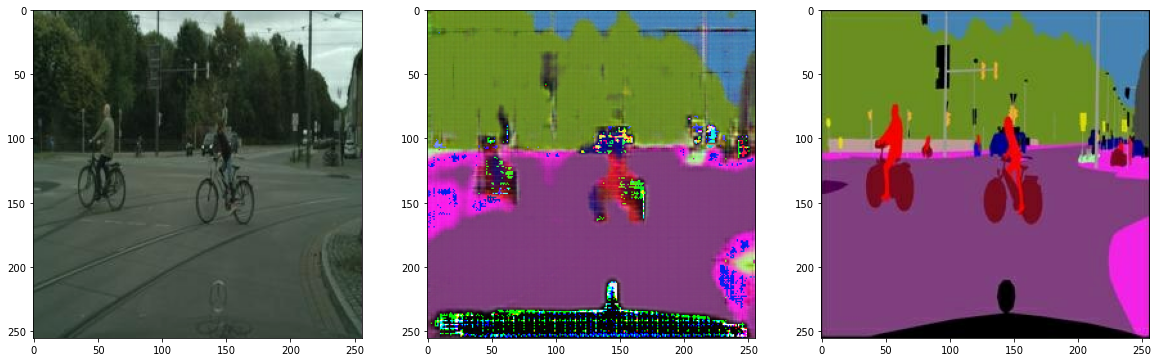

In [24]:
test_ind = 1
val_path = os.getenv('HOME')+'/aiffel/aiffel_exp_data/cityscapes/val/'

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

# 회고

PIX2PIX, UNET 구조를 대회때문에 공부했는데 다시보니 반가웠다.

gan에도 활용될 수 있음을 알게 됐다.